# Team defensive schemes
Does a team's defensive scheme influence opponents' shot portfolios? 
I'm going to be using [a different NBA API](https://github.com/vishaalagartha/basketball_reference_scraper) to query all the games for the 2018-2019 regular season.
In each game, I'm going to log each "make" against a team's defense.
For example, Houston makes a 22-ft 3-point shot against Boston, I will log the distance at which Houston scored against Boston.

I'm going to be presenting this as a matrix within a pandas DataFrame, where each row is the defensive team, each column is the offensive team, and each entry is a list of distances for every successful make (excluding free throws).
Conveniently, if you look across a row, you'll be examining that team's defense against all other teams.
Conversely, if you look down a column, you'll be examiniing that team's offense against all other teams.

Some caveats to this analysis:
* There are some errors to some game logs, but there are only a few, and those will have a negligible influence since each team plays 82 games anyways. 
* Player injuries may influence a team's defensive/offensive play, but hopefully the team's tactics still hold. 
* The game logs themselves may log each team's acctions "messily". If you look at the code, the logic to classify a make involves finding the word 'make' and not finding the word 'free throw'. On top of that, I'm doing some very rudimentary parsing to find the distance of each make. 
* Maybe I ought to normalize for pace or opposing team's "average" offensive skill/behavior, but just histogramming the counts of each make should hopefully be enough to get a sense of a defensive team's allowed-shot portfolio.
* Because we're only looking at "makes", a blocked shot and missed shot are both equally neglected when detecing "makes", although, in reality, a blocked shot could say more about the defender while a missed shot might say more about the shooter.

WARNING, the cell below takes over an hour to run

In [5]:
from basketball_reference_scraper.constants import TEAM_ABBR_TO_TEAM, TEAM_TO_TEAM_ABBR
from basketball_reference_scraper.seasons import get_schedule
from basketball_reference_scraper.shot_charts import get_shot_chart
from basketball_reference_scraper.pbp import get_pbp
import pandas as pd
from pprint import pprint
import time
start = time.time()

# Each row is the defensive team
# Each column is the offensive team
# Each element is a list of successful makes by the offensive team against the defensive team

TEAMS = ['ATLANTA', 'BOSTON', 'BROOKLYN', 'CHICAGO', 'CHARLOTTE', 
        'CLEVELAND', 'DALLAS', 'DENVER', 'DETROIT', 
         'GOLDEN STATE', 'HOUSTON', 'INDIANA', 'LA CLIPPERS', 
         'LA LAKERS', 'MEMPHIS', 'MIAMI', 'MILWAUKEE', 'MINNESOTA', 
         'NEW ORLEANS', 'NEW YORK', 'OKLAHOMA CITY', 'ORLANDO', 'PHILADELPHIA', 
         'PHOENIX', 'PORTLAND', 'SACRAMENTO', 'SAN ANTONIO', 'TORONTO', 
         'UTAH', 'WASHINGTON']# 'NEW JERSEY NETS', 
         #'NEW ORLEANS HORNETS', 'NEW ORLEANS OKLAHOMA CITY HORNETS', 'CHARLOTTE BOBCATS', 'SEATTLE SUPERSONICS', 'VANCOUVER GRIZZLIES']

# Because of how pandas converts dictionaries into dataframes,
# the "first" key is actually the column, while the "second" key is the row
# team_a is defending team, team_b is offending team
shots_dict = {team_a: {team_b:[] for team_b in TEAMS} for team_a in TEAMS}


s = get_schedule(2019, playoffs=False) # Schedule of all games in the 2018-2019 regular season
for i, series in s.iterrows():
    # Get play by play for the given game
    try:
        pbp = get_pbp(series['DATE'], 
                    TEAM_TO_TEAM_ABBR[series['HOME'].upper()], 
                    TEAM_TO_TEAM_ABBR[series['VISITOR'].upper()])
        teams = series[['HOME', 'VISITOR']] # teams['HOME'], teams['VISITOR']

        # Tidy up strings to format the team name and get the appropriation action
        if "LAKERS" in teams['HOME'].upper():
            home_team = 'LA LAKERS'
            home_actions = pbp['LA LAKERS_ACTION']
        elif "CLIPPERS" in teams['HOME'].upper():
            home_team = 'LA CLIPPERS'
            home_actions = pbp['LA CLIPPERS_ACTION']
        elif "TRAIL BLAZERS" in teams['HOME'].upper():
            home_team = 'PORTLAND'
            home_actions = pbp['PORTLAND_ACTION']
        else:
            home_team = ' '.join(a for a in teams['HOME'].split(' ')[:-1]).upper()
            home_actions = pbp[home_team.upper()+ "_ACTION"]

        if "LAKERS" in teams['VISITOR'].upper():
            visitor_team = 'LA LAKERS'
            visitor_actions = pbp['LA LAKERS_ACTION']
        elif "CLIPPERS" in teams['VISITOR'].upper():
            visitor_team = 'LA CLIPPERS'
            visitor_actions = pbp['LA CLIPPERS_ACTION']
        elif "TRAIL BLAZERS" in teams['VISITOR'].upper():
            visitor_team = 'PORTLAND'
            visitor_actions = pbp['PORTLAND_ACTION']
        else:
            visitor_team = ' '.join(a for a in teams['VISITOR'].split(' ')[:-1]).upper()
            visitor_actions = pbp[visitor_team.upper()+ "_ACTION"]

        # Look at the home team's actions, particularly those on offense
        for offense_action in home_actions[pd.notna(home_actions)]:
            words = offense_action.split(' ')
            success = 'makes' in offense_action and 'free throw' not in offense_action
            if success:
                if 'ft' not in words: # "makes 2-pt layup at rim"
                    shots_dict[home_team][visitor_team].append(0)
                else: # "makes 2-pt jump shot/layup from 3 ft"
                    distance_index = words.index('ft') - 1 
                    distance = int(words[distance_index])
                    shots_dict[home_team][visitor_team].append(distance)

        # Look at the visitor team's actions, particularly those on offense
        for offense_action in visitor_actions[pd.notna(visitor_actions)]:
            words = offense_action.split(' ')
            success = 'makes' in offense_action and 'free throw' not in offense_action
            if success:
                if 'ft' not in words: # "makes 2-pt layup at rim"
                    shots_dict[visitor_team][home_team].append(0)
                else: # "makes 2-pt jump shot/layup from 3 ft"
                    distance_index = words.index('ft') - 1 
                    distance = int(words[distance_index])
                    shots_dict[visitor_team][home_team].append(distance)
    except AttributeError:
        print(f"Error looking at game {i}")
        continue
end = time.time()
print('Looping took {} seconds'.format(end-start))
df = pd.DataFrame.from_dict(shots_dict)
df.to_pickle('data.pkl')

Error looking at game 2
Error looking at game 66
Error looking at game 95
Error looking at game 110
Error looking at game 125
Error looking at game 148
Error looking at game 224
Error looking at game 238
Error looking at game 251
Error looking at game 293
Error looking at game 305
Error looking at game 319
Error looking at game 337
Error looking at game 367
Error looking at game 404
Error looking at game 420
Error looking at game 429
Error looking at game 454
Error looking at game 468
Error looking at game 516
Error looking at game 542
Error looking at game 553
Error looking at game 665
Error looking at game 678
Error looking at game 743
Error looking at game 769
Error looking at game 775
Error looking at game 795
Error looking at game 872
Error looking at game 883
Error looking at game 896
Error looking at game 910
Error looking at game 943
Error looking at game 964
Error looking at game 976
Error looking at game 1058
Error looking at game 1073
Error looking at game 1086
Error looking

In [1]:
import pandas as pd
df = pd.read_pickle('data.pkl')

In [6]:
# Plotting a team's defense versus other teams
%matplotlib inline
import matplotlib.pyplot as plt
for i, series in df.iterrows():
    fig, ax = plt.subplots(6,5, figsize=(12,10), sharex=True, sharey=True)

    for j, off_team in enumerate(series.index):
        row = j // 5
        col = j % 5
        ax[row, col].hist(series[off_team], bins=[0, 5, 15, 22, 35], density=False)
        ax[row,col].set_ylabel(f"Makes by\n{off_team}")
        ax[row,col].set_xlabel("Distance (ft)")
        ax[row,col].set_xticks([0, 5, 15, 22, 35])
        ax[row,col].set_xticklabels([0, 5, 15, 22, 35])
        ax[row,col].set_ylim([0, 100])

    fig.tight_layout()
    simple_name = '_'.join(a for a in series.name.split(' '))
    fig.savefig(f"{simple_name}_defense.png", transparent=True)
    plt.close(fig)
    


# Worst NBA regular season defenses
Comparing the worst defenses and best defenses (below), the best defenses allow very few short-range shots relative to allowing long-range shots.
The worst defenses, however, seem to let a lot of layups and shots-in-the paint.

## Cleveland's Defense 18-19
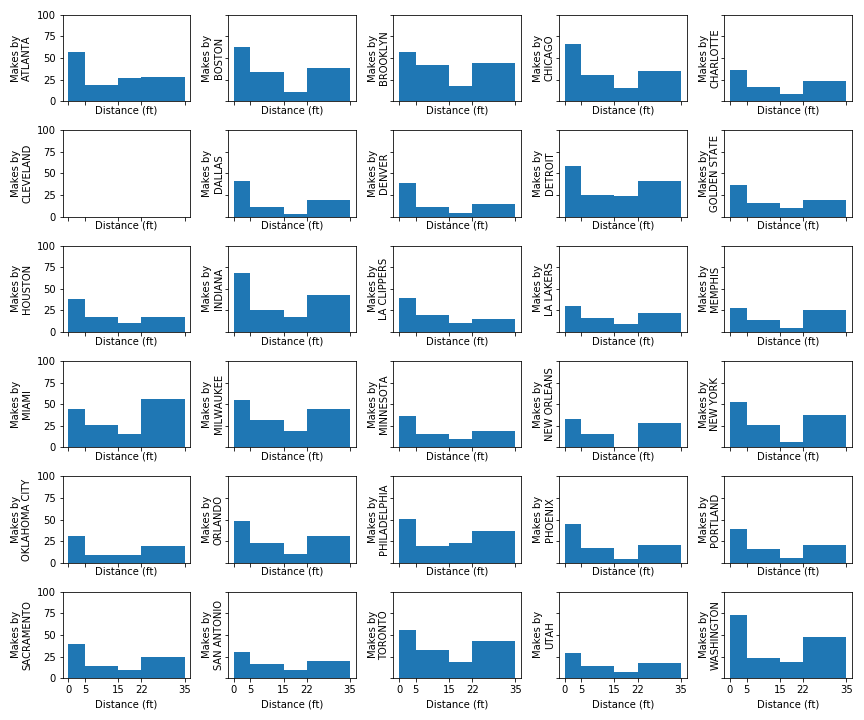

## Phoenix's Defense 18-19
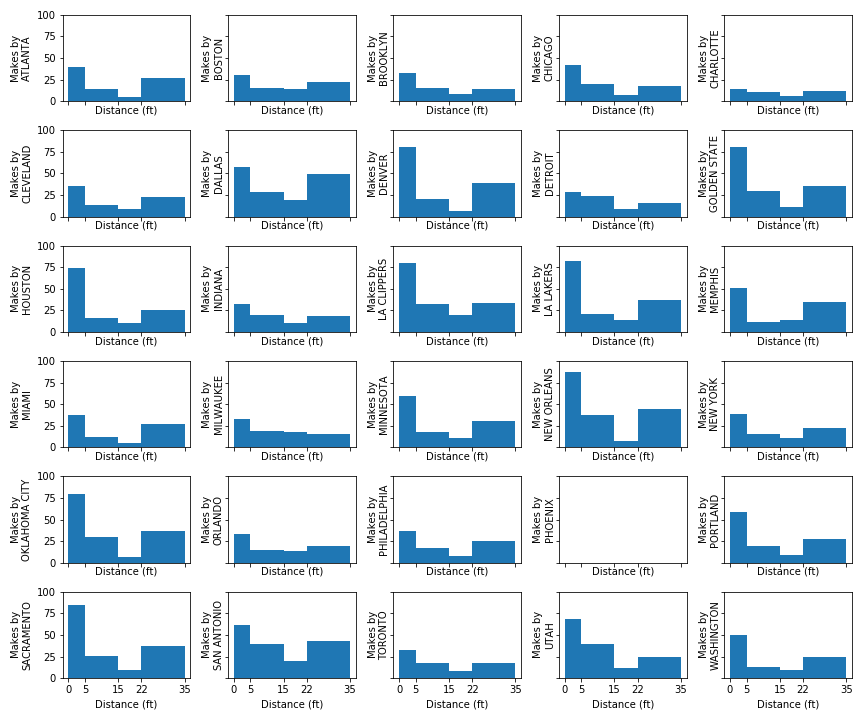

## Atlanta's Defense 18-19
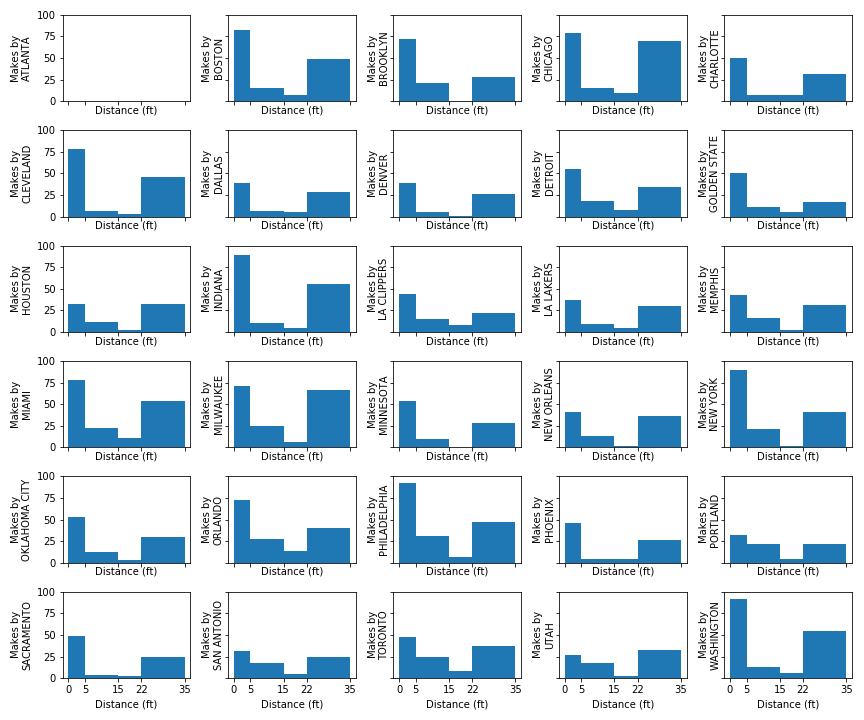

# Best NBA regular season defenses

## Milwaukee's Defense 18-19
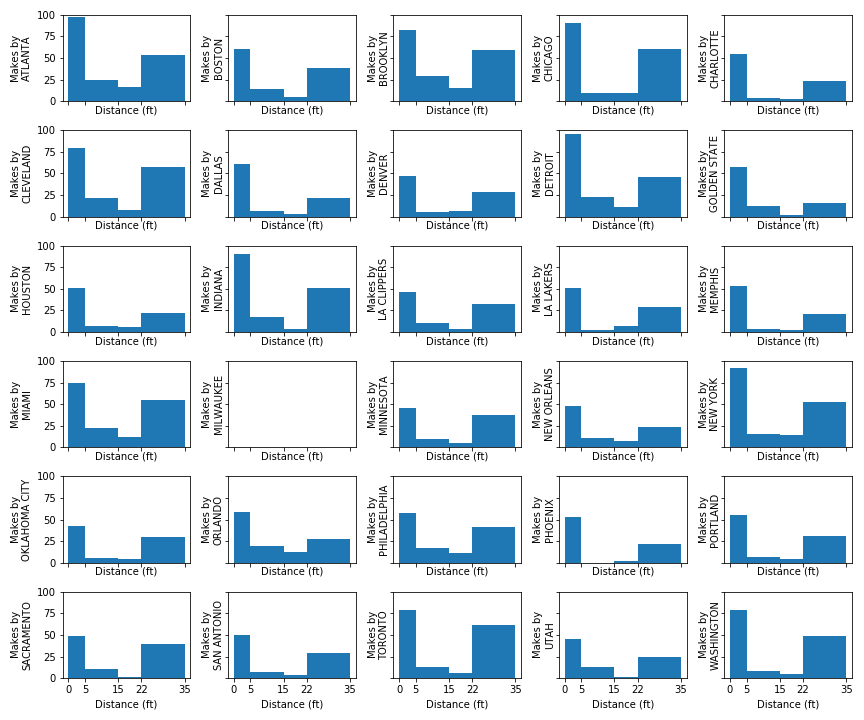

## Utah's Defense 18-19
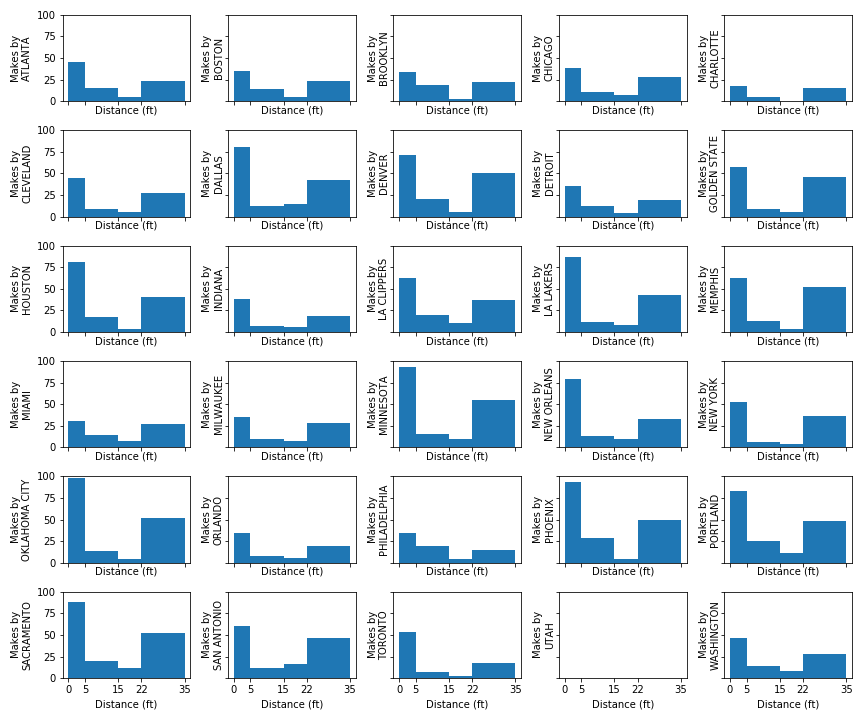

## Indiana's Defense 18-19
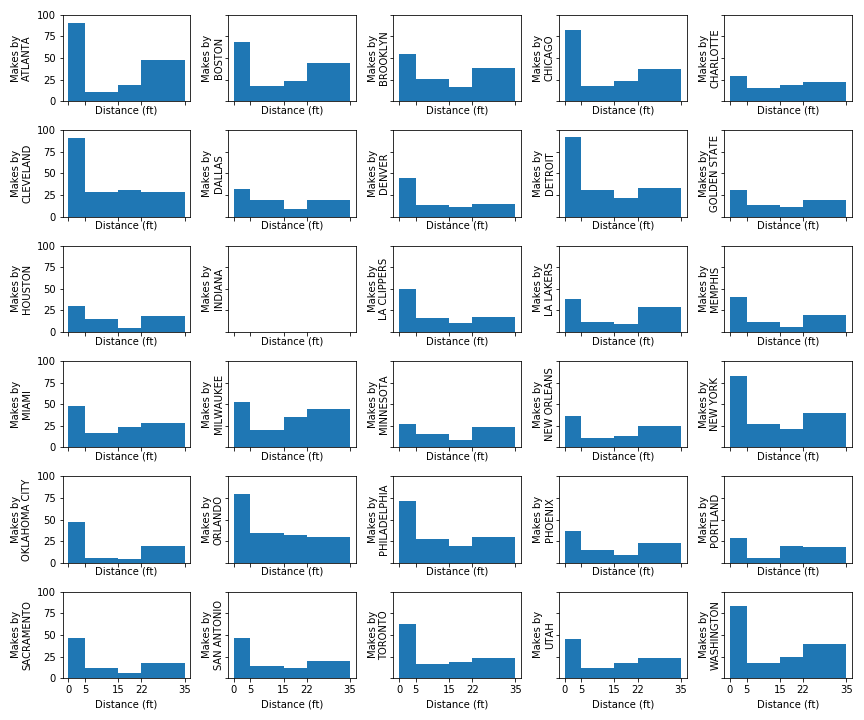

In [7]:
# Plotting a team's offense versus other teams
%matplotlib inline
import matplotlib.pyplot as plt
for column in df:
    fig, ax = plt.subplots(6,5, figsize=(12,10), sharex=True, sharey=True)

    for j, def_team in enumerate(df[column].index):
        row = j // 5
        col = j % 5
        ax[row, col].hist(df[column][def_team], bins=[0, 5, 15, 22, 35], density=False)
        ax[row,col].set_ylabel(f"Makes against\n{def_team}")
        ax[row,col].set_xlabel("Distance (ft)")
        ax[row,col].set_xticks([0, 5, 15, 22, 35])
        ax[row,col].set_xticklabels([0, 5, 15, 22, 35])
        ax[row,col].set_ylim([0, 100])

    fig.tight_layout()
    simple_name = '_'.join(a for a in column.split(' '))
    fig.savefig(f"{simple_name}_offense.png", transparent=True)
    plt.close(fig)
    


# Worst NBA regular season offenses (by PPG)

## Mempis' Offense 18-19
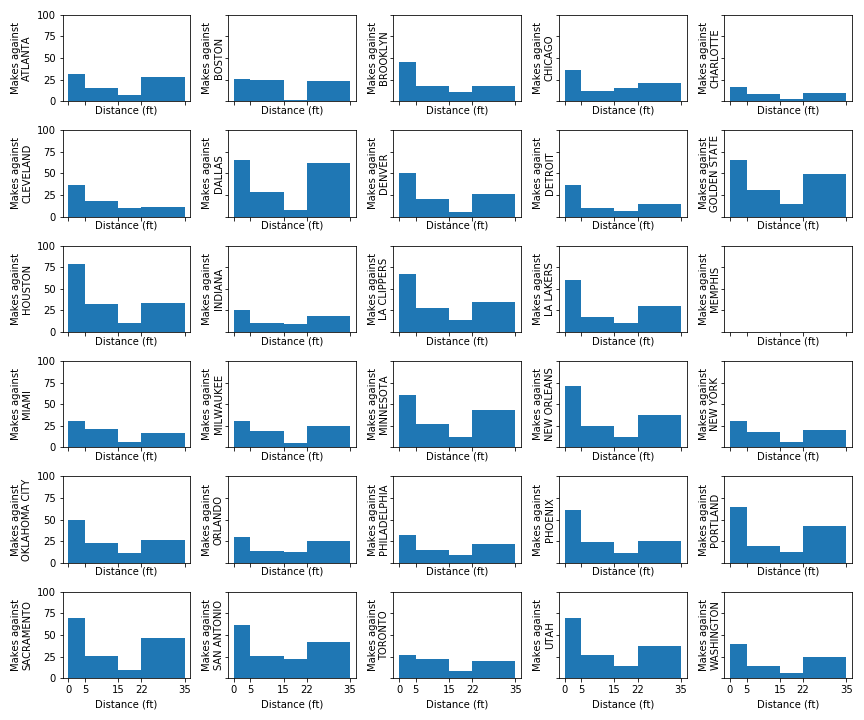

## New York's Offense 18-19
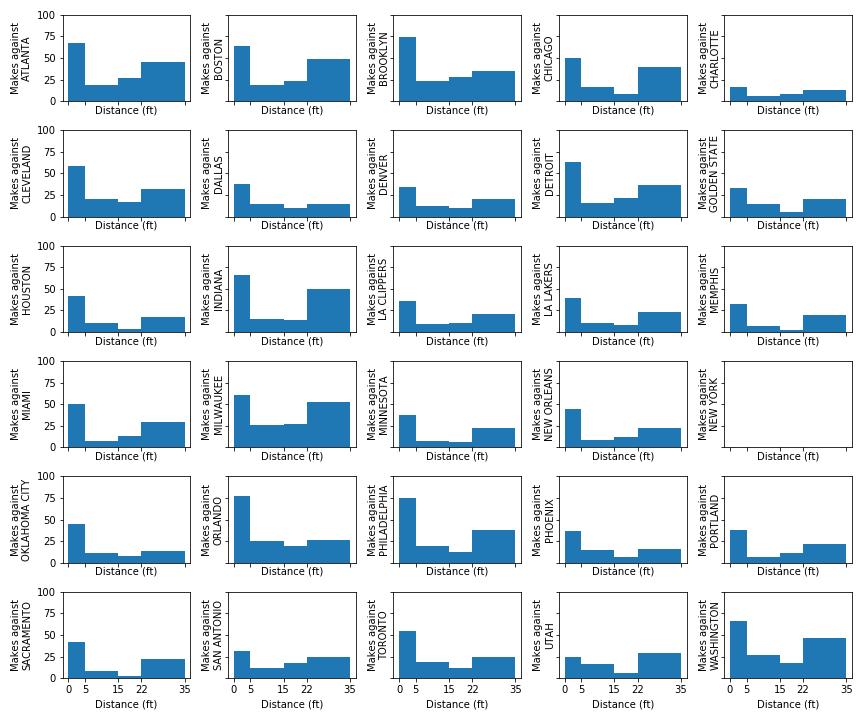

## Cleveland's Offense 18-19
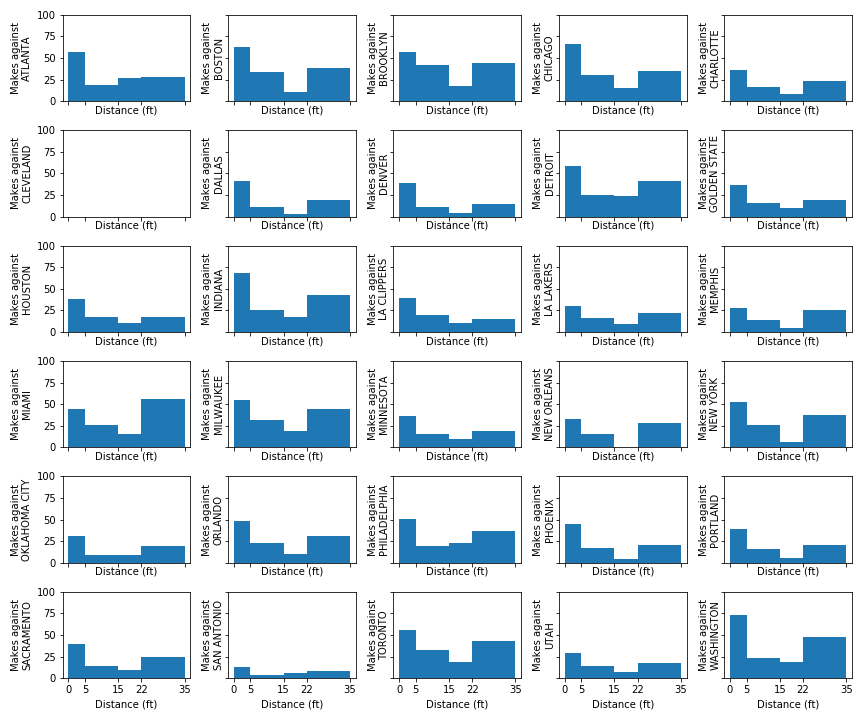

# Best NBA regular season offenses (by PPG)
We can see Milwaukee and New Orleans' offenses are very interior heavy, while Golden State has a relatively more balanced offense from all distances.

## Milwaukee's Offense 18-19
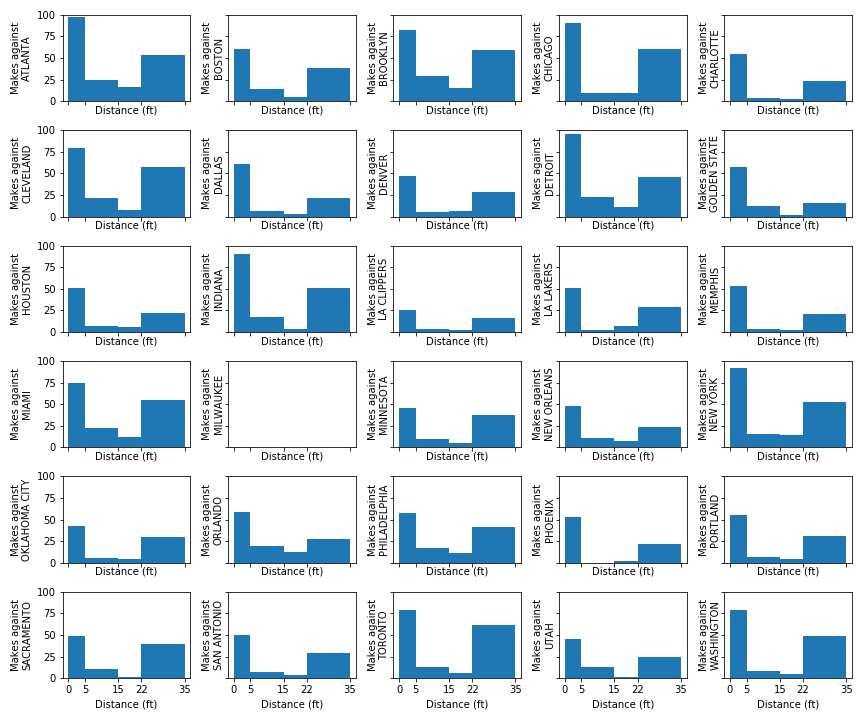

## Golden State's Offense 18-19
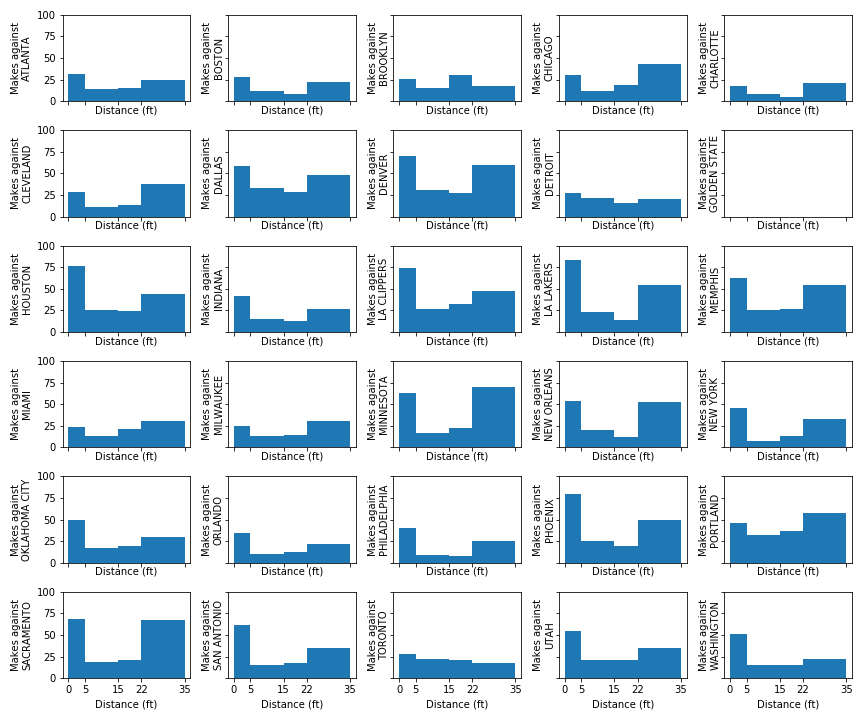

## New Orleans' Offense 18-19
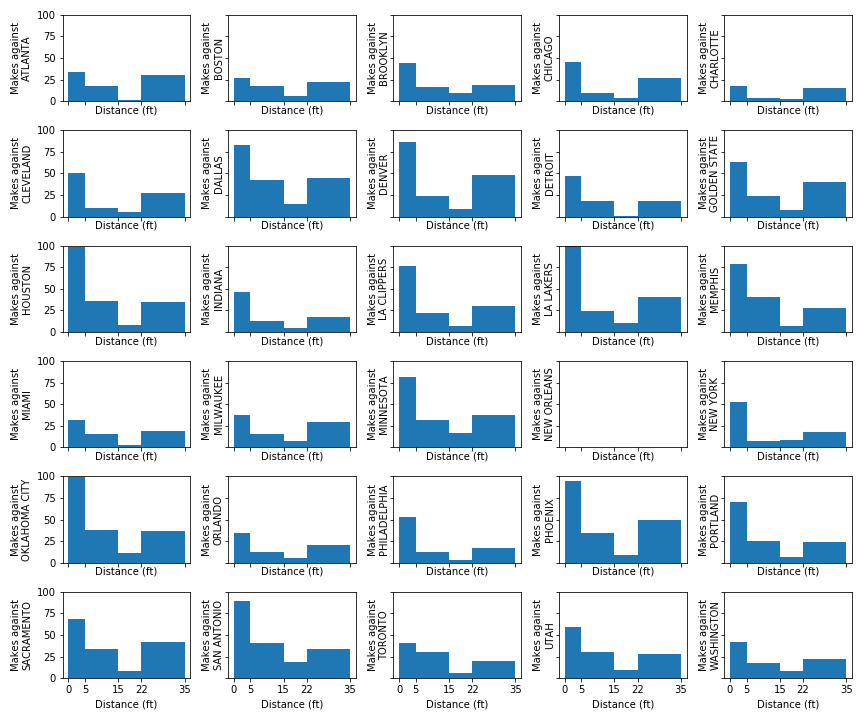

## For a sanity check, Houston's Offense 18-19
To make sure this method was "correct" we would expect Houston's offense to be low in mid-range shots
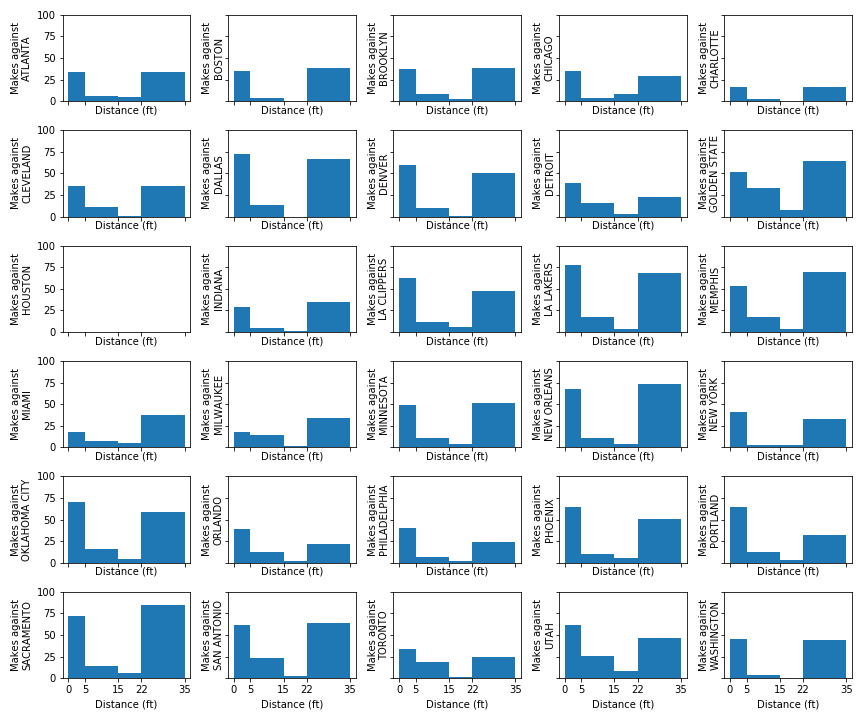
